In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [279]:
def data_generator(sample, degree, noise):
    np.random.seed(42)
    X = np.random.uniform(-10, 10, size = (sample,1))

    # The code below is the start of the polynomial feature section 
    cols = [X**i for i in range(1 , degree+1)]
    w = np.random.randint(1, 9, size = (degree))
    bias = 10
    X_poly = np.concatenate(cols, axis = 1)
    # The code above is the end of the polynomial feature section 
    # Ideally, when you already have the data, we write it inside the polynomial regression class, but because I'm working with 
    # Synthetic data is inside the data creation function
    
    y = np.dot(X_poly, w)+ bias + (np.random.randn(sample) * np.std(X_poly)* noise)
    
    return X, X_poly, y
      

# Data to work on

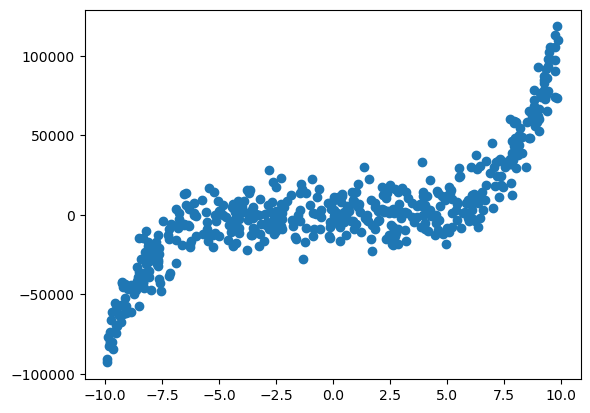

In [280]:
X, X_poly, y = data_generator(500, 5, 0.7)
fig, ax = plt.subplots()
ax.scatter(X, y)
plt.show()

In [281]:
def train_test_split(X, y, ratio, shuffle = False, seed = False):
    if seed:
        np.random.seed(seed)
    if shuffle:
        index = np.arange(len(X))
        np.random.shuffle(index)
        X, y = X[index], y[index]
    divider = int(len(X) * ratio)
    train_X = X[: divider]
    test_X = X[divider: ]
    train_y = y[: divider]
    test_y = y[divider: ]
    return train_X, train_y, test_X, test_y
    

In [282]:
raw_train_X, raw_train_y, raw_test_X, raw_test_y = train_test_split(X_poly, y, 0.7, shuffle = True, seed = 10) 

In [283]:
def standardize(X):
    mean = X.mean(axis = 0)
    std = X.std(axis = 0)
    X_scaled = (X - mean) / std
    return X_scaled

In [284]:
raw_train_X = standardize(train_X)
raw_test_X = standardize(test_X)

# Model creation


In [285]:
class PolynomialRegression:
    def __init__(self, lr, n_iter, method):
        self.lr = lr
        self.n_iter = n_iter
        self.method = method
        self.theta = None
        self.loss_history = []
        self.val_loss_history = []
         

    def _add_bias(self, X):
        b = np.ones((X.shape[0], 1))
        X = np.concatenate([b, X], axis = 1)
        return X
    
    def fit(self, X, y, X_val = None, y_val = None):
        X = self._add_bias(X)
        
        X_val = self._add_bias(X_val)
        
        '''
            prediction formula ===> y_pred = X_bias.θ
            where,
            X_bias = X matrix with all feature and bias in this case X_train with shape of (350, 6){5 feature + 1 bias}
            θ = model weights including bias (shape: (𝑑+1)×1(d+1)×1)

            But the above formula is for predict method, and in the fit method we have to find the θ
            So basically, solve for the θ in fit method and put it in the equation inside the predict method.

            θ = (transposed X . X)**(-1). (transposed X . y)
        '''
        if self.method == 'normal':
            self.theta = np.linalg.inv(X.T @ X) @ (X.T @ y)
            
        if self.method == 'gd':
            m,n = X.shape
            self.theta = np.zeros(n)
            for _ in range(self.n_iter):
                y_pred = X @ self.theta
                error = y_pred - y
                gradient = (1/m) * (X.T @ error)
                self.theta = self.theta - (self.lr * gradient)

                loss = (1 / (2*m)) * np.sum(error ** 2)
                self.loss_history.append(loss)

                if X_val is not None and y_val is not None:
                    y_val_pred = X_val @ self.theta
                    val_error = y_val_pred - y_val
                    val_loss = (1 / (2 * len(y_val))) * np.sum(val_error ** 2)
                    self.val_loss_history.append(val_loss)

    def loss_plot(self):
        fig, ax = plt.subplots()
        ax.plot(self.loss_history, label = 'training loss')
        ax.plot(self.val_loss_history, c = 'r', label = 'testing loss')
        ax.set_title('Loss descend over iterations')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Iterations')
        ax.legend()
        plt.show()
            
            
    
    def predict(self, X):
        X = self._add_bias(X)
        y_pred = X @ self.theta
        return y_pred

    def mean_squared_error(self, y_pred, y_true):
        return np.mean((y_true - y_pred) ** 2)


# Model execution

In [286]:
model = PolynomialRegression(lr = 0.01, n_iter = 200, method = 'gd')
model.fit(train_X, train_y, X_val = test_X, y_val = test_y)

# 📉 Training vs Validation Loss Over Iterations
### *This plot shows how the training and validation loss evolve over time as the model learns. A well-behaved curve indicates proper convergence and generalization. Divergence between the two can signal underfitting or overfitting.*

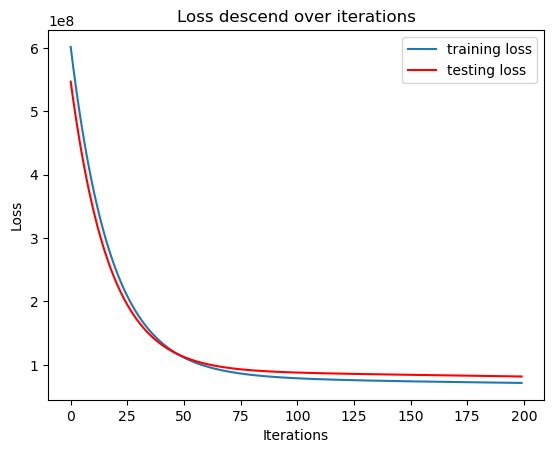

In [287]:
model.loss_plot()

# Visual Comparison: Ground Truth vs Model Output
### *Overlay of predicted and actual test values to visually validate the model’s performance.*

In [288]:
y_pred = model.predict(test_X)

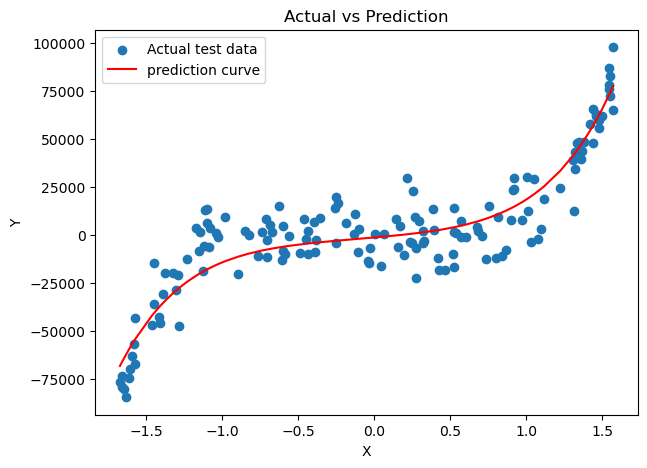

In [289]:
sorted_index = np.argsort(test_X[:, 0])
x_pts = test_X[sorted_index][:, 0]
y_pts = test_y[sorted_index]
y_pred_curve = y_pred[sorted_index]

fig, ax = plt.subplots(figsize = (7, 5))
ax.scatter(x_pts, y_pts, label = 'Actual test data')
ax.plot(x_pts, y_pred_curve, c = 'r', label = 'prediction curve')
ax.set_title('Actual vs Prediction')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

# root_mean_squared_error

In [290]:
rmse = np.sqrt(model.mean_squared_error(y_pred, test_y))
print("Test RMSE:", rmse)

Test RMSE: 12771.064124774279
